In [3]:
%load_ext autoreload
%autoreload 2

from src.racetrack import RaceTrack, tiny_course, big_course
from src.montecarlo import MonteCarloControl
from src.dp import DynamicProgramming
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import random

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Part 1: Dynamic Programming on the Racecar Environment

For this part of the assignment, implement both Policy Iteration and Value Iteration in `src/dp.py` to solve the Racecar environment using Dynamic Programming. In this part of the notebook, we will vidualize the results.

In [2]:
def plot_track(track, states=None):
    """
    Visualizes the racetrack and the trajectory of the car.
    
    Args:
        track: RaceTrack environment.
        states: List of state tuples (x, y, vx, vy) representing the trajectory.
    """
    course_layout = track.course.copy()

    if states is None:
        states = [tuple(track.get_state())]

    plt.figure(figsize=(8, 8))
    plt.imshow(np.flipud(course_layout.T), cmap="hot", interpolation="nearest")
    plt.title("Policy Visualization - Marker shows position, arrow shows velocity")

    for state in states:
        x, y, vx, vy = state
        y = course_layout.shape[1] - 1 - y  # Flip vertically to match plot orientation
        plt.plot(x, y, "bo", markersize=10)
        plt.arrow(x, y, vx, -vy, color="cyan", head_width=0.2, length_includes_head=True, zorder=100)

    plt.show()

def simulate_policy(env, policy, max_steps=100):
    """
    Simulates the racetrack environment using a given policy.
    
    Args:
        env: RaceTrack environment.
        policy: Optimized policy from Dynamic Programming.
        max_steps: Maximum number of steps to simulate.
    
    Returns:
        List of visited states.
    """
    env.reset()
    trajectory = [tuple(env.get_state())]

    for _ in range(max_steps):
        state = tuple(env.get_state())
        if state not in policy:
            break
        action = int(policy[state])
        env.take_action(action)
        trajectory.append(tuple(env.get_state()))

        if env.is_terminal_state():
            break

    return trajectory

# Run Dynamic Programming for both methods
env = RaceTrack(tiny_course)

The code snippet below will run your Policy Iteration implementation on the Racecar environment.

{(1, 0, -4, -4): 0, (1, 0, -4, -3): 6, (1, 0, -4, -2): 8, (1, 0, -4, -1): 6, (1, 0, -4, 0): 8, (1, 0, -4, 1): 8, (1, 0, -4, 2): 3, (1, 0, -4, 3): 4, (1, 0, -4, 4): 0, (1, 0, -3, -4): 3, (1, 0, -3, -3): 8, (1, 0, -3, -2): 5, (1, 0, -3, -1): 8, (1, 0, -3, 0): 0, (1, 0, -3, 1): 4, (1, 0, -3, 2): 2, (1, 0, -3, 3): 4, (1, 0, -3, 4): 3, (1, 0, -2, -4): 5, (1, 0, -2, -3): 1, (1, 0, -2, -2): 5, (1, 0, -2, -1): 3, (1, 0, -2, 0): 6, (1, 0, -2, 1): 2, (1, 0, -2, 2): 3, (1, 0, -2, 3): 2, (1, 0, -2, 4): 0, (1, 0, -1, -4): 0, (1, 0, -1, -3): 4, (1, 0, -1, -2): 4, (1, 0, -1, -1): 1, (1, 0, -1, 0): 4, (1, 0, -1, 1): 5, (1, 0, -1, 2): 2, (1, 0, -1, 3): 1, (1, 0, -1, 4): 7, (1, 0, 0, -4): 2, (1, 0, 0, -3): 4, (1, 0, 0, -2): 4, (1, 0, 0, -1): 7, (1, 0, 0, 0): 4, (1, 0, 0, 1): 8, (1, 0, 0, 2): 3, (1, 0, 0, 3): 7, (1, 0, 0, 4): 1, (1, 0, 1, -4): 6, (1, 0, 1, -3): 8, (1, 0, 1, -2): 3, (1, 0, 1, -1): 8, (1, 0, 1, 0): 3, (1, 0, 1, 1): 3, (1, 0, 1, 2): 1, (1, 0, 1, 3): 1, (1, 0, 1, 4): 7, (1, 0, 2, -4): 8, (1,

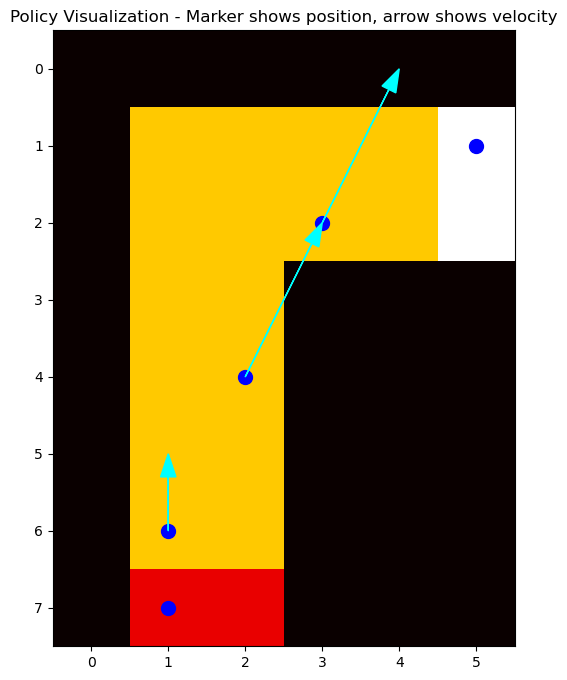

In [6]:
# Policy Iteration
dp_solver_pi = DynamicProgramming(env)
dp_solver_pi.solve(method='policy_iteration')
trajectory_pi = simulate_policy(env, dp_solver_pi.policy)
plot_track(env, trajectory_pi)

And the snippet below will run your Value Iteration implementation on the Racecar environment.

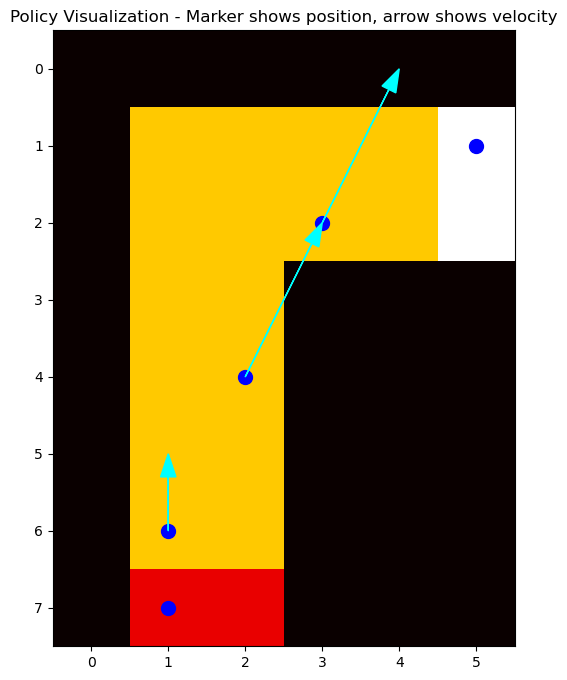

In [10]:
# Value Iteration
dp_solver_vi = DynamicProgramming(env)
dp_solver_vi.solve(method='value_iteration')
trajectory_vi = simulate_policy(env, dp_solver_vi.policy)
plot_track(env, trajectory_vi)

Optionally, you may try this out on the larger racecar environments.

# Part 2: Monte Carlo Control

Let's collect episodes where we behave using $\epsilon$-greedy policy and update a greedy policy using weighted importance sampling. 

We will use the code you wrote, and try to solve a small racecourse.  We will collect information about the behavior policy during learning, and at the end of learning we will collect a single episode per learner of the greedy target policy

Be warned, running this took 8 minutes using my code solution on a 2019 Macbook 2.4 GHz 8 core i9 operating in a conda COGS188Wi25 environment. Obviously YMMV according to your code's efficiency and the hardware/system setup.

In [109]:
random.seed(619) # replicability 

steps = []
behavior_rewards = []
target_rewards = []
for j in tqdm(range(20)):
    MC = MonteCarloControl(RaceTrack(tiny_course), max_episode_size=250)
    this_steps = []
    this_rewards = []
    for k in range(2000):
        episode = MC.generate_egreedy_episode()
        this_rewards.append( pd.DataFrame(episode).iloc[:,-1].sum() )
        this_steps.append(len(episode))
        MC.update_offpolicy(episode)
    steps.append(this_steps)
    behavior_rewards.append(this_rewards)
    episode = MC.generate_greedy_episode()
    target_rewards.append( pd.DataFrame(episode).iloc[:,-1].sum() )


100%|██████████| 20/20 [09:20<00:00, 28.03s/it]


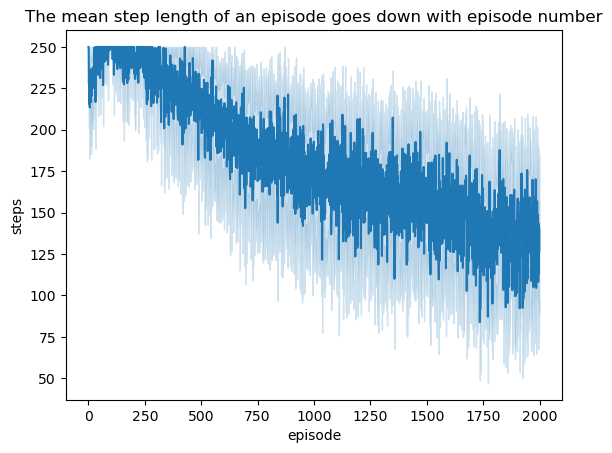

Welp at least there is some indication of learning


In [110]:

df1 = pd.DataFrame(steps)
df1.columns.name = 'episode'
df1.index.name = 'learner'
df1 = df1.stack().rename('steps').to_frame()

sns.lineplot( data=df1, x='episode', y='steps');
plt.title('The mean step length of an episode goes down with episode number')
plt.show()
print('Welp at least there is some indication of learning')


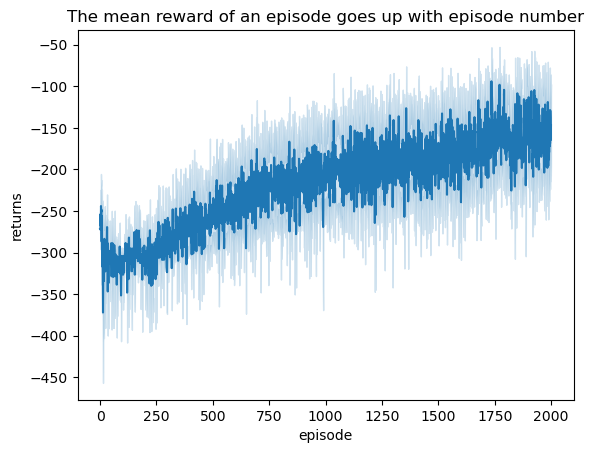

Welp at least there is some indication of learning


In [111]:

df2 = pd.DataFrame(behavior_rewards)
df2.columns.name = 'episode'
df2.index.name = 'learner'
df2 = df2.stack().rename('returns').to_frame()


df3 = pd.DataFrame(target_rewards)
df3.columns.name = 'episode'
df3.index.name = 'learner'
df3 = df3.stack().rename('returns').to_frame()

sns.lineplot( data=df2, x='episode', y='returns');
plt.title('The mean reward of an episode goes up with episode number')
plt.show()
print('Welp at least there is some indication of learning')

                returns                  
                    min median max    IQR
condition                                
behavior policy    -322 -276.0  -3  115.0
target policy      -262 -250.0  -5    0.0


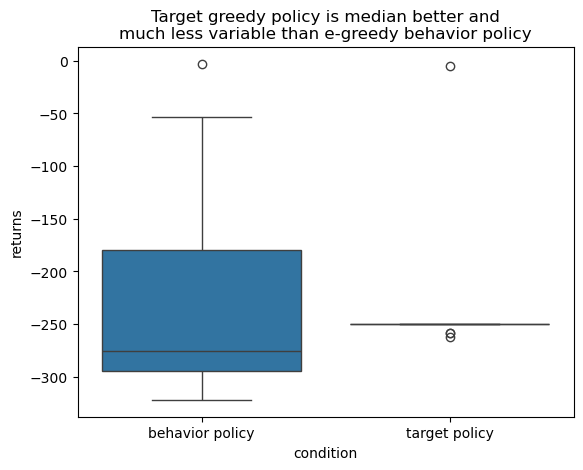

We can also see that (at least at the current number of episodes) even greedy sometimes is still failing hard


In [112]:
c1 = df2.query('episode==999').reset_index().drop(columns=['episode'])
c1['condition']='behavior policy'
c2 = df3.droplevel('episode').reset_index()
c2['condition']='target policy'

compare = pd.concat( [c1, c2], ignore_index=True)
sns.boxplot(data=compare, x='condition', y='returns');
plt.title('Target greedy policy is median better and\nmuch less variable than e-greedy behavior policy');


def IQR(column): 
    q25, q75 = column.quantile([0.25, 0.75])
    return q75-q25

stats_list = [
    'min', 'median', 'max', IQR  
]

print(compare.drop(columns=['learner']).groupby('condition').agg(stats_list))
plt.show()
print('We can also see that (at least at the current number of episodes) even greedy sometimes is still failing hard')

In [113]:
#plot_track(MC.env, episode)
MC.create_target_greedy_policy()
episode = MC.generate_greedy_episode()
#print(episode)
#print(MC.C)
print(MC.greedy_policy)
print(episode)

defaultdict(<function MonteCarloControl.__init__.<locals>.<lambda> at 0x0000024A71D20AE0>, {(2, 1, 0, 0): array([0., 1., 0., 0., 0., 0., 0., 0., 0.]), (2, 1, 1, 1): array([0., 1., 0., 0., 0., 0., 0., 0., 0.]), (1, 0, 0, 0): array([0., 1., 0., 0., 0., 0., 0., 0., 0.]), (2, 0, 0, 0): array([0., 1., 0., 0., 0., 0., 0., 0., 0.]), (1, 4, 0, 2): array([0., 0., 0., 0., 1., 0., 0., 0., 0.]), (1, 2, 0, 1): array([0., 0., 0., 0., 0., 0., 1., 0., 0.]), (1, 1, 0, 0): array([0., 1., 0., 0., 0., 0., 0., 0., 0.]), (1, 1, 0, 1): array([0., 0., 0., 1., 0., 0., 0., 0., 0.]), (2, 1, 1, 0): array([0., 0., 0., 0., 0., 0., 0., 0., 1.]), (2, 2, 0, 0): array([0., 1., 0., 0., 0., 0., 0., 0., 0.]), (2, 2, 0, 1): array([0., 0., 0., 1., 0., 0., 0., 0., 0.]), (2, 1, 0, 1): array([0., 0., 0., 0., 1., 0., 0., 0., 0.]), (1, 2, 0, 0): array([1., 0., 0., 0., 0., 0., 0., 0., 0.]), (2, 4, 0, 0): array([0., 0., 0., 1., 0., 0., 0., 0., 0.]), (2, 4, 0, 1): array([0., 0., 0., 1., 0., 0., 0., 0., 0.]), (2, 3, 0, 0): array([0.

In [108]:
print(MC.get_greedy_policy())

{(1, 0, 0, 0): 1, (2, 6, 0, 0): 1, (2, 6, 0, 1): 7, (2, 5, 0, 0): 1, (2, 5, 0, 1): 6, (2, 4, 0, 2): 7, (2, 2, 0, 1): 7, (2, 1, 0, 0): 0, (2, 1, 0, 1): 3, (2, 0, 0, 0): 5, (2, 1, 1, 0): 4, (1, 1, 0, 0): 1, (1, 1, 0, 1): 8, (2, 1, 1, 1): 2, (2, 0, 1, 0): 2, (3, 5, 0, 0): 4, (3, 5, 1, 1): 6, (2, 4, 0, 0): 1, (2, 4, 1, 0): 1, (1, 4, 0, 0): 2, (1, 4, 0, 1): 4, (1, 3, 0, 0): 2, (1, 3, 0, 1): 7, (1, 2, 0, 0): 3, (1, 2, 0, 1): 4, (2, 2, 0, 0): 1, (4, 6, 0, 0): 5, (4, 6, 1, 0): 3, (3, 6, 0, 0): 1, (3, 6, 1, 1): 6, (2, 4, 0, 1): 4, (2, 3, 0, 2): 3, (2, 3, 0, 0): 7, (2, 3, 0, 1): 7, (1, 5, 0, 0): 2, (1, 5, 0, 1): 3, (1, 3, 0, 2): 6, (4, 6, 2, 0): 0, (2, 6, 1, 0): 0, (1, 6, 0, 0): 1, (1, 6, 0, 1): 3, (2, 5, 0, 2): 8, (2, 6, 0, 2): 6, (2, 6, 0, 3): 2, (1, 6, 0, 2): 1, (3, 5, 1, 0): 6, (1, 5, 0, 2): 7, (2, 2, 1, 1): 4, (4, 6, 2, 3): 4, (2, 3, 1, 2): 0, (4, 6, 1, 1): 3, (4, 6, 0, 1): 3, (4, 5, 0, 0): 6, (4, 5, 1, 0): 3, (3, 6, 0, 1): 6, (2, 3, 1, 1): 0, (1, 4, 0, 2): 4, (3, 5, 1, 2): 5, (3, 6, 1, 3):

# Try the bigger course
Lets just run the bigger racecourse for longer because we know this is going to take longer to learn due to the larger state space.  At first I tried single runs out to >20k episodes and it still wasn't working until I tried a trick...

A Q0=-50 is helpful because it encourages the system to learn more quickly... Any return that is better than 50 moves looks like a real good deal! This is the opposite of a positive Q0 that encourages exploration, here we ask the MC to lock in quickly and exploit as soon as it finds a somewhat OK solution.  With that mod in place we finally get reasonable learning in reasonable time.  Without it (feel free to try!) I just ran out of patience and time.

But note that while we've found an OK solution already, its likely that a much better unfound solution still exists, and would obviously take >>20k episodes to learn with this kind of e-greedy exploration to randomly find this better solution

Be warned even with this trick this run took 9 minutes to run on my Macbook. 



In [117]:
random.seed(42) # replicability 

steps = []
behavior_rewards = []
target_rewards = []
for j in tqdm(range(20)):
    MC = MonteCarloControl(RaceTrack(big_course), max_episode_size=500, Q0=-50)
    this_steps = []
    this_rewards = []
    for k in range(2500):
        episode = MC.generate_egreedy_episode()
        this_rewards.append( pd.DataFrame(episode).iloc[:,-1].sum() )
        this_steps.append(len(episode))
        MC.update_offpolicy(episode)
    steps.append(this_steps)
    behavior_rewards.append(this_rewards)
    episode = MC.generate_greedy_episode()
    target_rewards.append( pd.DataFrame(episode).iloc[:,-1].sum() )


100%|██████████| 20/20 [34:03<00:00, 102.15s/it]


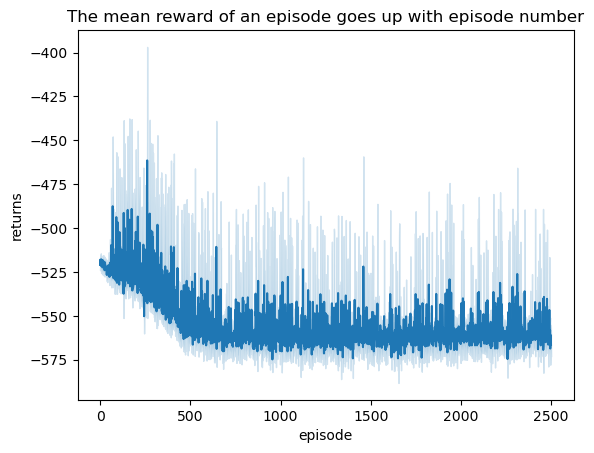

Welp at least there is some indication of learning


In [118]:

df2 = pd.DataFrame(behavior_rewards)
df2.columns.name = 'episode'
df2.index.name = 'learner'
df2 = df2.stack().rename('returns').to_frame()


df3 = pd.DataFrame(target_rewards)
df3.columns.name = 'episode'
df3.index.name = 'learner'
df3 = df3.stack().rename('returns').to_frame()

sns.lineplot( data=df2, x='episode', y='returns');
plt.title('The mean reward of an episode goes up with episode number')
plt.show()
print('Welp at least there is some indication of learning')

                returns                  
                    min median  max   IQR
condition                                
behavior policy    -584 -556.0 -540  18.0
target policy      -504 -500.0 -500   0.0


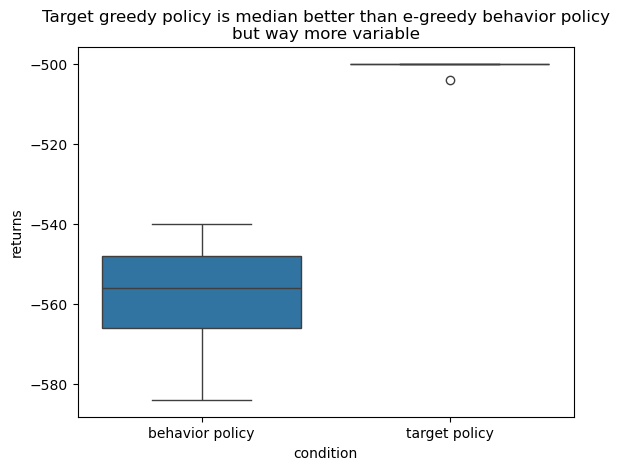

Here's more evidence that the training duration is too short... while target policy is better than the behavior at the median it has some spectacularly bad learners at 2500 episodes


In [119]:
c1 = df2.query('episode==1999').reset_index().drop(columns=['episode'])
c1['condition']='behavior policy'
c2 = df3.droplevel('episode').reset_index()
c2['condition']='target policy'

compare = pd.concat( [c1, c2], ignore_index=True)
sns.boxplot(data=compare, x='condition', y='returns');
plt.title('Target greedy policy is median better than e-greedy behavior policy\nbut way more variable');

print(compare.drop(columns=['learner']).groupby('condition').agg(stats_list))
plt.show()
print('Here\'s more evidence that the training duration is too short... while target policy is better than the behavior at the median it has some spectacularly bad learners at 2500 episodes')

In [52]:
import numpy as np

def plot_track(track, states=None):
    # Get a copy of the course layout and the current position.
    course_layout = track.course.copy()

    if not states:
        states = [np.concatenate(track.get_state())]

    # Set up the figure.
    plt.figure(figsize=(8, 8))
    # Plot the course as a heatmap.
    # Note: We flip the image vertically to match the coordinate system.
    plt.imshow(np.flipud(course_layout.T), cmap="hot", interpolation="nearest")
    plt.title("One episode, marker shows position, arrow shows velocity")

    for astate in states:
        # Transform the current position to match the flipud effect.
        # x coordinate remains the same; y coordinate is flipped.
        s = astate[0]
        
        s1T = course_layout.shape[1] - 1 - s[1]

        # Overlay the current position.
        plt.plot(s[0], s1T, "bo", markersize=10)
        
        plt.arrow(
            s[0],
            s1T,
            s[2],
            -s[3],
            color="cyan",
            head_width=0.2,
            length_includes_head=True,
            zorder=100
        )
    plt.show()

In [130]:
print(MC.greedy_policy)

defaultdict(<function MonteCarloControl.__init__.<locals>.<lambda> at 0x0000024A73511260>, {(7, 1, 0, 0): array([0., 0., 0., 0., 1., 0., 0., 0., 0.]), (7, 1, 1, 0): array([0., 0., 0., 0., 0., 0., 0., 1., 0.]), (6, 1, 0, 0): array([0., 1., 0., 0., 0., 0., 0., 0., 0.]), (6, 1, 0, 1): array([0., 0., 0., 1., 0., 0., 0., 0., 0.]), (6, 0, 0, 0): array([0., 1., 0., 0., 0., 0., 0., 0., 0.]), (6, 0, 1, 0): array([0., 0., 1., 0., 0., 0., 0., 0., 0.]), (5, 0, 0, 0): array([0., 1., 0., 0., 0., 0., 0., 0., 0.]), (9, 2, 0, 0): array([0., 1., 0., 0., 0., 0., 0., 0., 0.]), (9, 2, 0, 1): array([0., 0., 0., 1., 0., 0., 0., 0., 0.]), (9, 1, 0, 0): array([0., 0., 0., 0., 0., 0., 0., 0., 1.]), (9, 1, 1, 0): array([0., 0., 0., 0., 0., 0., 1., 0., 0.]), (8, 1, 0, 0): array([0., 0., 0., 1., 0., 0., 0., 0., 0.]), (8, 1, 1, 0): array([0., 0., 0., 0., 0., 0., 0., 1., 0.]), (7, 1, 0, 1): array([0., 0., 1., 0., 0., 0., 0., 0., 0.]), (7, 0, 0, 0): array([0., 0., 0., 0., 0., 0., 1., 0., 0.]), (9, 8, 0, 0): array([0.

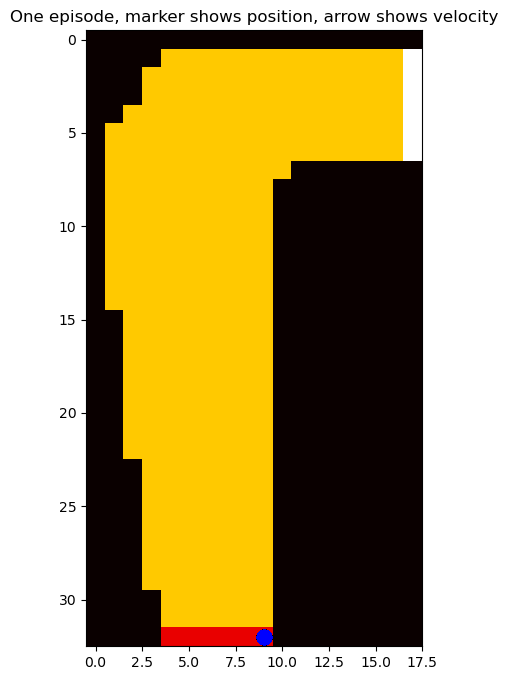

In [145]:
# feel free to use this technique to explore solutions you train!
episode = MC.generate_greedy_episode() 
plot_track(MC.env, episode)

# On policy updating

OK lets see if there's any difference when we use on an on-policy e-greedy first visit algorithm to learn.

Warning (at least my implementation) is extremely slow!  Even downgrading this to only 5 trials of 2000 episodes each this is going to take 30 minutes

In [95]:
random.seed(42) # replicability 

steps_on = []
behavior_rewards_on = []
target_rewards_on = []
trials = 5
for j in range(trials):
    MC = MonteCarloControl(RaceTrack(tiny_course), max_episode_size=250)
    this_steps = []
    this_rewards = []
    for k in tqdm(range(1000), desc='trial {} of {}'.format(j,trials)):
        episode = MC.generate_egreedy_episode()
        this_rewards.append( pd.DataFrame(episode).iloc[:,-1].sum() )
        this_steps.append(len(episode))
        MC.update_onpolicy(episode)
    steps_on.append(this_steps)
    behavior_rewards_on.append(this_rewards)
    episode = MC.generate_greedy_episode()
    target_rewards_on.append( pd.DataFrame(episode).iloc[:,-1].sum() )
    

trial 4 of 5: 100%|██████████| 1000/1000 [00:21<00:00, 46.11it/s]


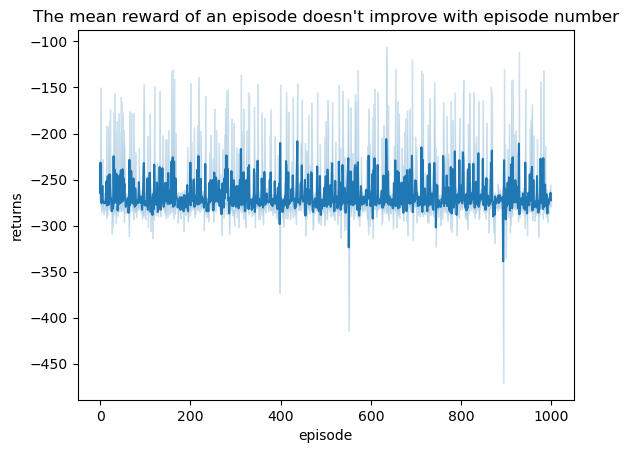

NO indication of learning.  Perhaps we need way more episodes than I am willing to try?


In [96]:
df2_on = pd.DataFrame(behavior_rewards_on)
df2_on.columns.name = 'episode'
df2_on.index.name = 'learner'
df2_on = df2_on.stack().rename('returns').to_frame()


df3_on = pd.DataFrame(target_rewards_on)
df3_on.columns.name = 'episode'
df3_on.index.name = 'learner'
df3_on = df3_on.stack().rename('returns').to_frame()

sns.lineplot( data=df2_on, x='episode', y='returns');
plt.title('The mean reward of an episode doesn\'t improve with episode number')
plt.show()
print('NO indication of learning.  Perhaps we need way more episodes than I am willing to try?')